#### Assignment 3 - Practice Software Development Course 22S
- Prepared by: Carla Mae Arellano
- Practice Software Development repository: [PLUS_softwaredev_2022](https://github.com/cmmarellano/PLUS_SoftwareDev2022_environment)


#### Convolutional Neural Network (CNN) implementation
- The goal of this notebook is to present and recreate a CNN LULC classification of the EuroSAT dataset using Keras toolbox
- The environment file used is "[Py37_mldl.yml](https://github.com/cmmarellano/PLUS_SoftwareDev2022_environment)", created from Assignment 2. See on Github for full documentation on environment creation.


Main References: <br>
[1] [Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification](https://github.com/phelber/eurosat). Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019. <br>
[2] [Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification](https://github.com/phelber/eurosat). Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018. <br>
[3] [Keras basic toolbox for image recognition](https://www.kaggle.com/code/rnogueras/keras-basic-toolbox-for-image-recognition). Roberto Nogueras Zondag. Kaggle, 2021. <br>
[4] [EuroSAT Land Use and Land Cover Classification using Deep Learning](https://colab.research.google.com/github/e-chong/Remote-Sensing/blob/master/EuroSAT%20Land%20Cover%20Classification/EuroSAT%20Land%20Use%20and%20Land%20Cover%20Classification%20using%20Deep%20Learning.ipynb). Eugene Chong. Google Colab, 2020.



## Importing libraries
- numpy
- matplotlib
- seaborn
- sklearn
- tensorflow

In [1]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image
import seaborn as sns

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Block Numa warning

### Loading the EuroSAT data
- The EuroSAT dataset is a collection of 27,000 Sentinel 2 images. The researchers behind this project provided two versions of this dataset: (1) .tif of multispectral S2 images in 10m resolution; and (2) in .jpg with RGB channels.
- The dataset is comprised of 10 classes:
    - AnnualCrop
    - Forest
    - HerbaceousVegatation
    - Highway
    - Industrial
    - Pasture
    - PermanentCrop
    - Residential
    - River
    - SeaLake
- Three (3) sets of the data will be used for the whole deep learning application: *training, validation, and test*

In [3]:
input_folder = "D:/Todai/Conda/EuroSAT/"
dataset_folder = input_folder+"2750/"

In [4]:
column_names =  ["id", "path", "class_id", "class_name"]

training_df = pd.read_csv(dataset_folder + "train.csv", names=column_names)
validation_df = pd.read_csv(dataset_folder + "validation.csv", names=column_names)
test_df = pd.read_csv(dataset_folder + "test.csv", names=column_names)

- Datasets <br>
The sizes of the training, validation, and test sets are:

In [5]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


- Rescaling to prevent memory overload
- Set a rescaling factor rather than utilizing [tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [6]:
rescaling_factor = 1. / 255

In [7]:
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

In [8]:
image_width = 64
image_height = 64

- Set batch size of processing

In [9]:
batch_size = 128

In [10]:
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

D:\Todai\Conda\Install\envs\forCarla\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 18900 validated image filenames belonging to 10 classes.


D:\Todai\Conda\Install\envs\forCarla\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


D:\Todai\Conda\Install\envs\forCarla\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


### Analyzing the data

- Count of images per class (training set)

In [11]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


In [12]:
figure_height = 3
figure_width = 3
figure_size = (14, 14)

- Visualizing the dataset in 3 x 3 grids (random)

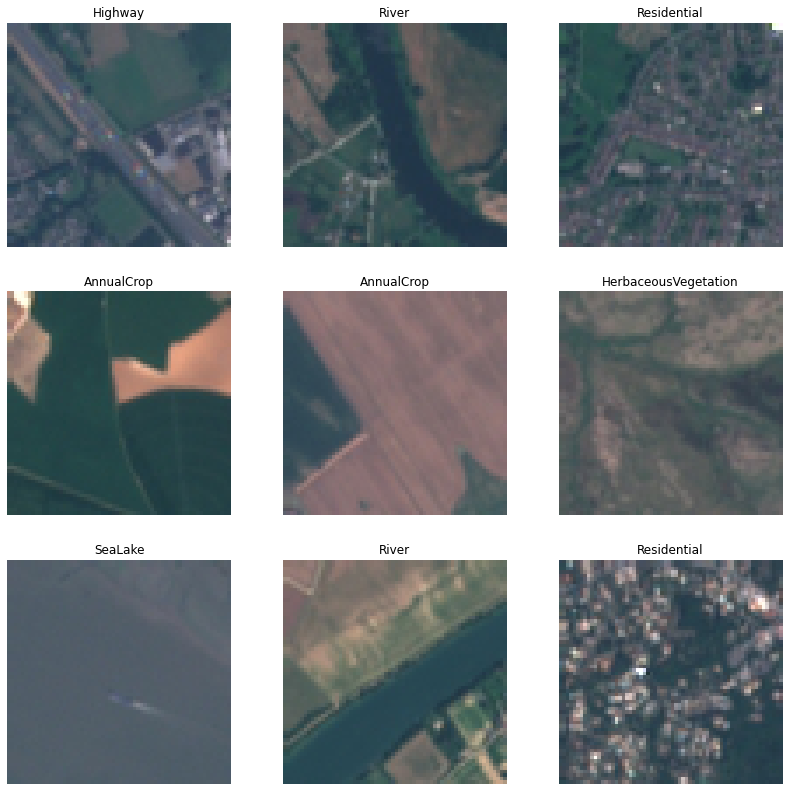

In [13]:
images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

### Training
- The model chosen for training is VGG16. The architecture summary of the convolutional backbone is given below.


In [14]:
base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

- Defining the custom layers for the classification head part of the architecture.

In [15]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


- Adding callback functions

In [16]:
model_path = "/kaggle/working/models/eurosat_rgb_model.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

- Compiling the model

In [17]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

- Training proper

In [18]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=100,
    verbose=1,
)

Epoch 1/100
148/148 [==============================] - 874s 6s/step - loss: 0.6985 - accuracy: 0.7579 - val_loss: 0.2354 - val_accuracy: 0.9228
Epoch 2/100
148/148 [==============================] - 903s 6s/step - loss: 0.2416 - accuracy: 0.9230 - val_loss: 0.1618 - val_accuracy: 0.9469
Epoch 3/100
148/148 [==============================] - 920s 6s/step - loss: 0.1466 - accuracy: 0.9518 - val_loss: 0.1346 - val_accuracy: 0.9531
Epoch 4/100
148/148 [==============================] - 935s 6s/step - loss: 0.1078 - accuracy: 0.9657 - val_loss: 0.1388 - val_accuracy: 0.9543
Epoch 5/100
148/148 [==============================] - 999s 7s/step - loss: 0.1034 - accuracy: 0.9677 - val_loss: 0.1426 - val_accuracy: 0.9554
Epoch 6/100
148/148 [==============================] - 938s 6s/step - loss: 0.0777 - accuracy: 0.9747 - val_loss: 0.1333 - val_accuracy: 0.9639
Epoch 7/100
148/148 [==============================] - 986s 7s/step - loss: 0.0733 - accuracy: 0.9766 - val_loss: 0.1570 - val_accuracy:

### Metrics from Training
- Plotting the *loss* and *Accuracy* curves
- The minima was found at around 15 epoch, but stopped overall at 30 epoch (early stopping)

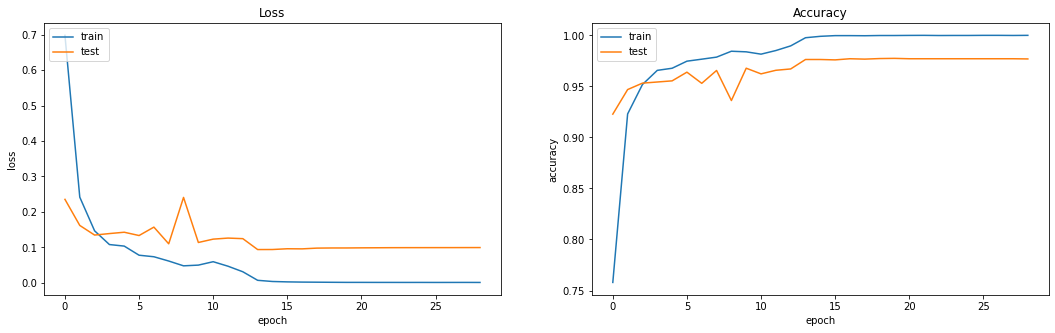

In [19]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

### Model Accuracy

In [20]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 26s 1s/step - loss: 0.0780 - accuracy: 0.9830


In [21]:
test_set.reset()

In [22]:
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 26s 9ms/step


#### Confusion matrix
- Plotting the confusion matrix as a *seaborn* confusion matrix / heatmap

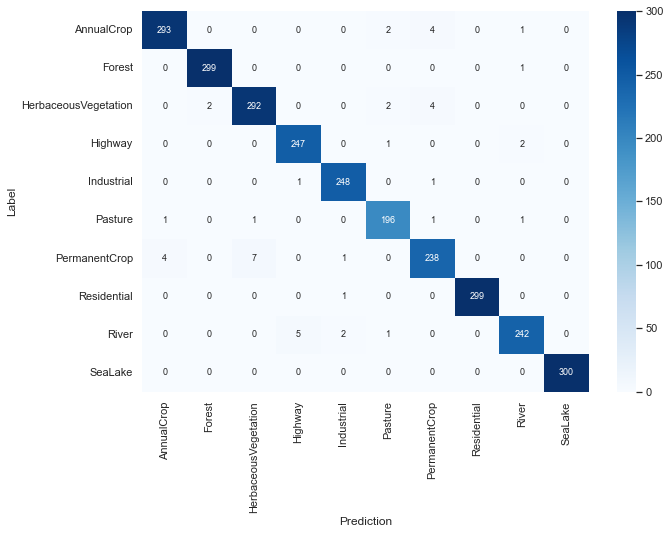

In [23]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()

- Compiling image sets by label and "prediction" result

In [24]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

#### Visualizing the misclassified results
- 46 / 2700 wrong prediction

In [25]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

46 wrong predictions out of 2700


In [26]:
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

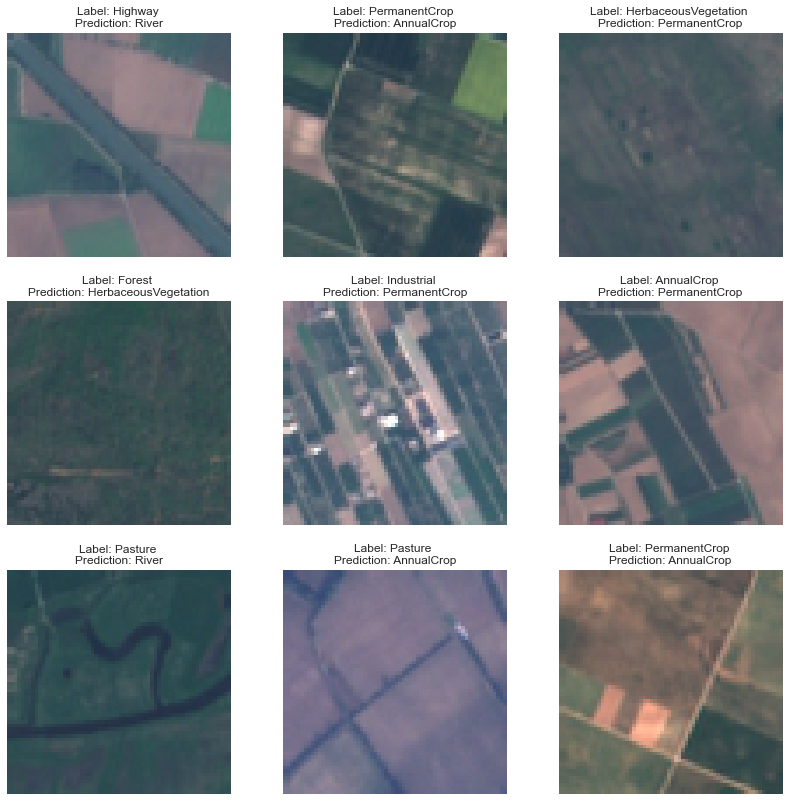

In [27]:
figure_size = (14, 14)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

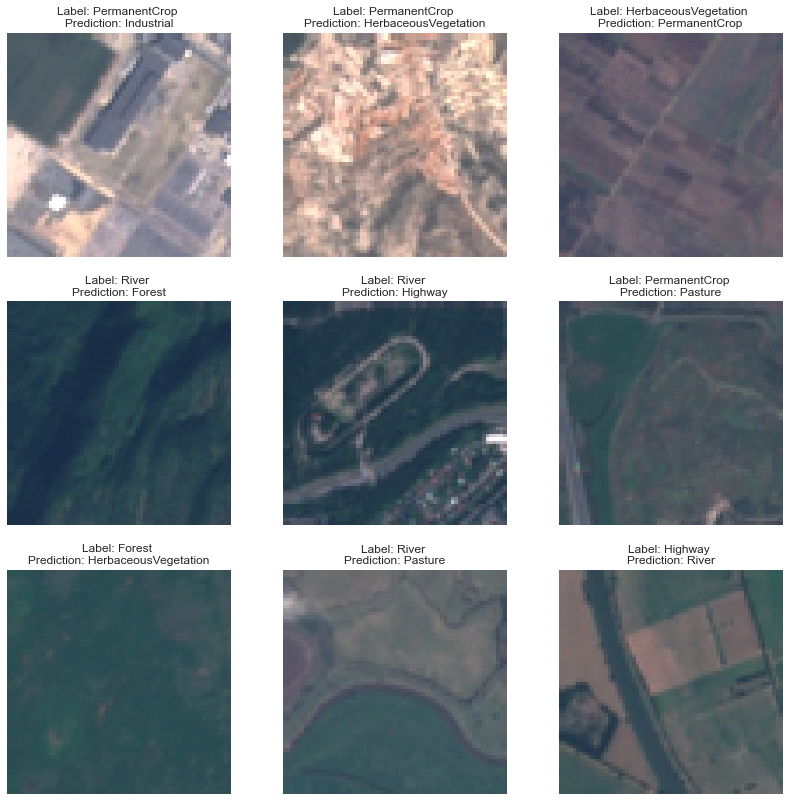

In [42]:
figure_size = (14, 14)   #run 2
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

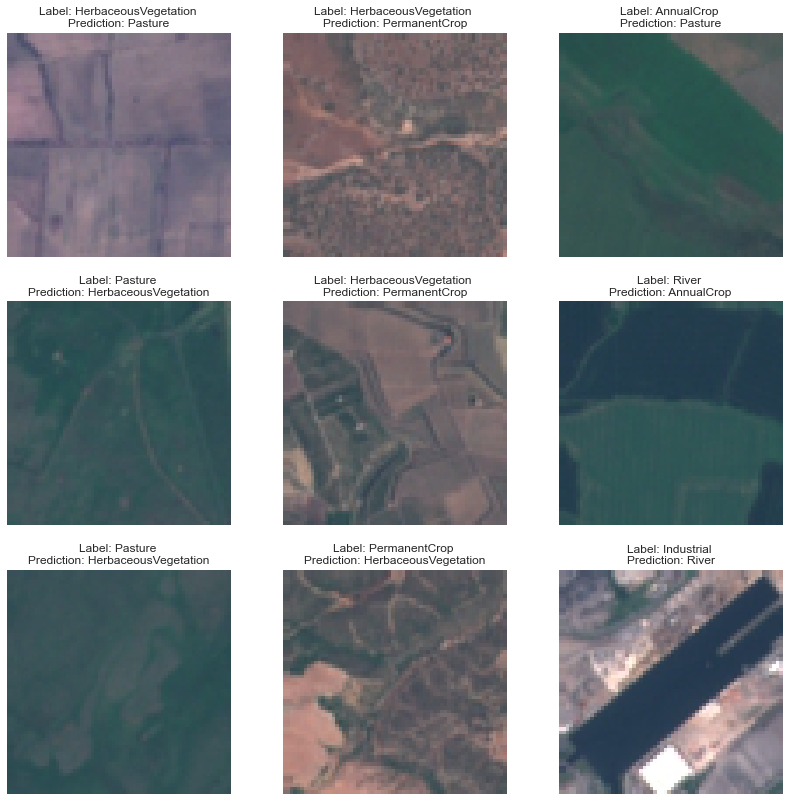

In [43]:
figure_size = (14, 14) #run 3
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

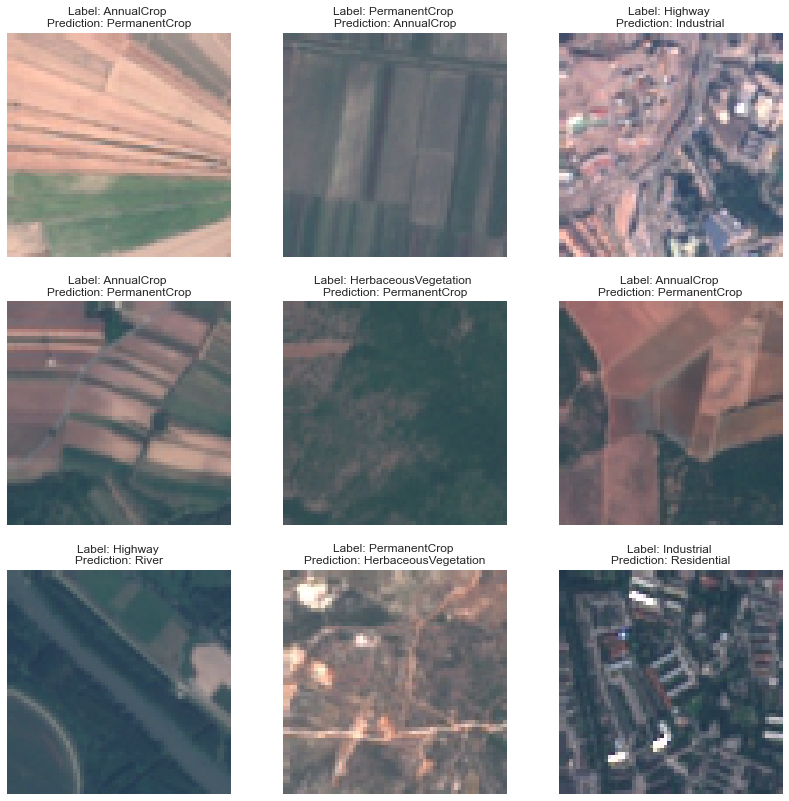

In [44]:
figure_size = (14, 14) #run 4
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

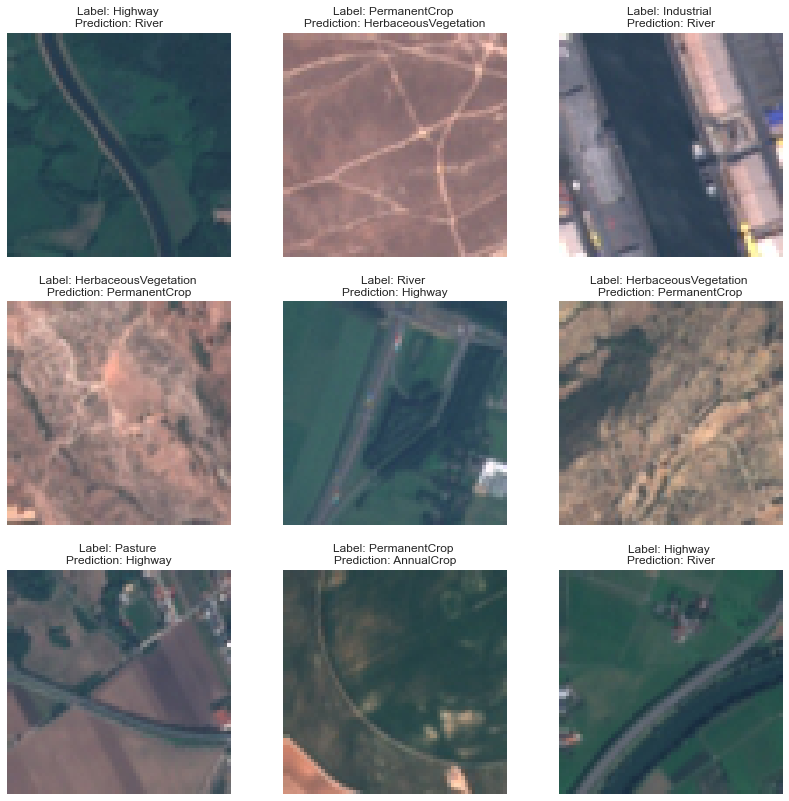

In [45]:
figure_size = (14, 14)  #run 5

plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

In [33]:
print(confusion_matrix_df)

                      AnnualCrop  Forest  HerbaceousVegetation  Highway  \
AnnualCrop                   293       0                     0        0   
Forest                         0     299                     0        0   
HerbaceousVegetation           0       2                   292        0   
Highway                        0       0                     0      247   
Industrial                     0       0                     0        1   
Pasture                        1       0                     1        0   
PermanentCrop                  4       0                     7        0   
Residential                    0       0                     0        0   
River                          0       0                     0        5   
SeaLake                        0       0                     0        0   

                      Industrial  Pasture  PermanentCrop  Residential  River  \
AnnualCrop                     0        2              4            0      1   
Forest        

In [36]:
from sklearn.metrics import precision_recall_fscore_support

prf1 = precision_recall_fscore_support(y_true=test_set.labels, y_pred=predicted_class_ids)

print(prf1)

(array([0.98322148, 0.99335548, 0.97333333, 0.97628458, 0.98412698,
       0.97029703, 0.95967742, 1.        , 0.97975709, 1.        ]), array([0.97666667, 0.99666667, 0.97333333, 0.988     , 0.992     ,
       0.98      , 0.952     , 0.99666667, 0.968     , 1.        ]), array([0.97993311, 0.99500832, 0.97333333, 0.98210736, 0.98804781,
       0.97512438, 0.95582329, 0.99833055, 0.97384306, 1.        ]), array([300, 300, 300, 250, 250, 200, 250, 300, 250, 300], dtype=int64))


In [41]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_set.labels, y_pred=predicted_class_ids, average=None)
print(precision)

[0.98322148 0.99335548 0.97333333 0.97628458 0.98412698 0.97029703
 0.95967742 1.         0.97975709 1.        ]


In [52]:
cm = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(cm)
print("FP")
print(FP)
print("FN")
print(FN)
print("TP")
print(TP)
print("TN")
print(TN)



print(f" TPR =  {TPR}    sensitivity, recall")
print(f" TNR =  {TNR}       specificity")
print(f" PPV =  {PPV}     precision")


print("Accuracy")
print(ACC)



[[293   0   0   0   0   2   4   0   1   0]
 [  0 299   0   0   0   0   0   0   1   0]
 [  0   2 292   0   0   2   4   0   0   0]
 [  0   0   0 247   0   1   0   0   2   0]
 [  0   0   0   1 248   0   1   0   0   0]
 [  1   0   1   0   0 196   1   0   1   0]
 [  4   0   7   0   1   0 238   0   0   0]
 [  0   0   0   0   1   0   0 299   0   0]
 [  0   0   0   5   2   1   0   0 242   0]
 [  0   0   0   0   0   0   0   0   0 300]]
FP
[ 5  2  8  6  4  6 10  0  5  0]
FN
[ 7  1  8  3  2  4 12  1  8  0]
TP
[293 299 292 247 248 196 238 299 242 300]
TN
[2395 2398 2392 2444 2446 2494 2440 2400 2445 2400]
 TPR =  [0.97666667 0.99666667 0.97333333 0.988      0.992      0.98
 0.952      0.99666667 0.968      1.        ]    sensitivity, recall
 TNR =  [0.99791667 0.99916667 0.99666667 0.99755102 0.99836735 0.9976
 0.99591837 1.         0.99795918 1.        ]       specificity
 PPV =  [0.98322148 0.99335548 0.97333333 0.97628458 0.98412698 0.97029703
 0.95967742 1.         0.97975709 1.        ]     p